In [30]:
using LinearAlgebra, Random, Statistics, Plots, MLDatasets, ImageCore

┌ Info: Precompiling ImageCore [a09fc81d-aa75-5fe9-8630-4744c3626534]
└ @ Base loading.jl:1186


# Weak random features

Here we'll generate data using the so-called weak random features model:

1. the first `num_informative_features` features are noisy versions of the label `y`
2. the rest of the features are pure noise 

We're interested in understanding the optimal model complexity as a function of the number of features we choose, in each of these models.

## Questions

1. How does the optimal model complexity depend on the noise in the features?
2. When does the error curve exhibit a "double descent" behavior? When is the best model found on the first descent vs the second descent?
3. How does this phenomenon depend on the choice of optimizer / regularizer, for underconstrained problems?

In [31]:
function random_features(n=100,d=100; num_informative_features = 20)
    y = randn(n)
    X = randn(n,min(d,num_informative_features)) .+ y
    if d > num_informative_features
        X = hcat(X, randn(n,d - num_informative_features))
    end
    return X,y
end

random_features (generic function with 3 methods)

  0.757413 seconds (292.79 k allocations: 357.397 MiB, 8.72% gc time)


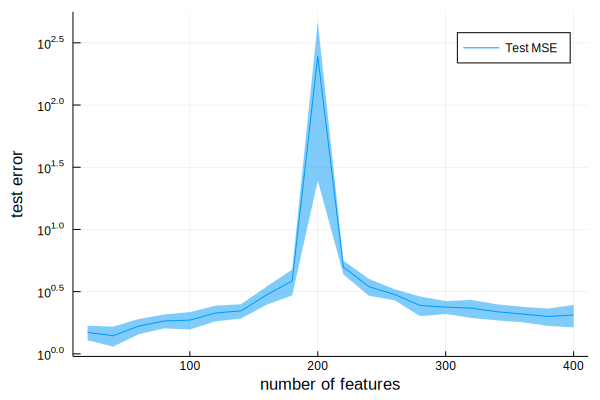

In [32]:
n = 200
ds=20:20:2n
num_informative_features = 10 # try 10, 100, 1000
nreps = 10

mses = zeros(length(ds),nreps)
train_errors = zeros(length(ds),nreps)
@time for rep in 1:nreps
    mse = []
    train_error = []
    for d in ds
        Xtrain,ytrain = random_features(n,d; num_informative_features=num_informative_features)
        w = Xtrain\ytrain
        Xtest,ytest = random_features(Int(n/10),d; num_informative_features=num_informative_features)
        push!(mse, norm(ytest-Xtest*w))
        push!(train_error, norm(ytrain-Xtrain*w))
    end
    mses[:,rep] = mse
    train_errors[:,rep] = train_error
end
mean_mse = mean(mses,dims=2)
std_mse = std(mses,dims=2)
mean_te = mean(train_errors,dims=2)
std_te = std(train_errors,dims=2)

std_mse = min.(std_mse,.9mean_mse) # a hack to ensure we don't try to plot a negative number on a log plot
std_te = min.(std_te,.9mean_te) # a hack to ensure we don't try to plot a negative number on a log plot
plot(ds,mean_mse,ribbon=std_mse,label="Test MSE")
# plot!(ds,mean_te,ribbon=std_te,label="Train MSE")
yaxis!(:log)
ylabel!("test error")
xlabel!("number of features")

## Observations: 

1. The error blows up as $d \to n$.
2. With 10 informative features, the best test error occurs for d as small as possible.
3. With 100 informative features, the best test error occurs around d=100.
4. When all features are informative, the best test error occurs as $d \to \infty$ (or, at least, as large as we tested).

# MNIST

MNIST is a dataset of images with 784 grayscale pixels, representing digits. We will be fitting classifiers to this dataset, and hopefully recovering the double descent curve.

Instead of operating on the pixels direclty, we are going to use a ReLU features: that is, we will take a random matrix, then use it to transform the raw pixels into $d$ features. We will throw away all the nonnegative numbers beceause this makes our initial transformation nonlinear, which actually makes the entire model more expressive (this is common practice in deep nets, although we are not training the first layer at all).

We use a procedure with decaying gradient stepsize, and play with regularizers as well (everything except the regularizers is usable, but the regularizers are a little hacky; we recommend other example code provided in this class).

Let's first load the data, then write up all the utility functions necessary.

In [33]:
# read data 

Xtrain, ytrain = MNIST.traindata()
Xtest,  ytest  = MNIST.testdata()

Xtrain = MNIST.convert2features(Xtrain)'
Xtest = MNIST.convert2features(Xtest)'

10000×784 Adjoint{Normed{UInt8,8},Base.ReshapedArray{Normed{UInt8,8},2,Base.ReinterpretArray{Normed{UInt8,8},3,UInt8,Array{UInt8,3}},Tuple{}}}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [34]:
# view training data as images; eg the 5th example:
MNIST.convert2image(MNIST.traintensor(5))

In [35]:
function convert2psi(ys, n = 10)
    psis = -1.0*ones(length(ys), n)
    for i in 1:length(ys)
        psis[i, ys[i] + 1] = 1.0
    end
    return psis
end

psiTrain = convert2psi(ytrain)
psiTest = convert2psi(ytest)

10000×10 Array{Float64,2}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0
 -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
  ⋮                             ⋮                          
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  

In [36]:
ReLU(x) = max(x,0)

struct RandomFeatureMap
    W::AbstractArray
end
RandomFeatureMap(din,dout) = RandomFeatureMap(randn(din,dout))

function featurize(X,M::RandomFeatureMap)
    return ReLU.(X*M.W)
end

featurize (generic function with 1 method)

In [37]:
function hinge(ys, preds)
    return ReLU.((-ys.*preds).+1)
end

function hingeDerivative(ys, preds)
    return sign.(hinge(ys, preds)).*(-ys)
end

function linDerivatives(X, outDers)
    bDer = zeros(size(outDers)[2])
    WDer = zeros(size(outDers)[2]).*transpose(zeros(size(X)[2]))
    for i in 1:(size(X)[1])
        bDer += outDers[i, :]
        WDer += outDers[i, :].*transpose(X[i, :])
    end
    return WDer, bDer
end

linDerivatives (generic function with 1 method)

In [38]:
function predictedClass(preds)
    _, h = findmax(preds, dims=2)
    ypred = [element[2] - 1 for element in h]
    return ypred
end

function accuracy(y, ypred)
    # Unlike the other losses, this one takes the actual class labels as input, not the transformed inputs (psis)
    return sum(y.==ypred)/length(y)
end

accuracy (generic function with 1 method)

In [39]:
function layer1step(Loss, W, b, Wder, bder, eps = 0.01)
    targetChange = eps*Loss
    expectedChange = sum(bder.^2) + sum(Wder.^2) + 1.0
    r = min(abs(targetChange/expectedChange), 1)
    #println(r)
    return min.(max.(W - transpose(Wder).*r, -10), 10), min.(max.(b - bder.*r, -10), 10)
end

function gradDescent(Xs, psis, ys, maxTrain = 100, eps = 0.1, decay = false, l2lambda = 0.0)
    d = size(Xs)[2]
    k = size(psis)[2]
    W = randn(d, k)./(d^0.5) #Useful regularization to make the sum in the ballpark of 1.0
    b = randn(k)
    accsTrain = zeros(maxTrain)
    for i in 1:maxTrain
        preds = Xs*W.+transpose(b)
        Losses = hinge(psis, preds)
        L = sum(Losses)
#        Ls[i] = L
        accTrain = accuracy(ys, predictedClass(preds))
        accsTrain[i] = accTrain
#        accTest = accuracy(ytest, predictedClass(Xtest*W.+transpose(b)))
#        accsTest[i] = accTest
        println("\n\nIteration")
        println(i)
        println("Loss")
        println(L)
        println("Train Accuracy")
        println(accTrain)
#        println("Test Accuracy")
#        println(accTest)
        outDers = hingeDerivative(psis, preds)
        Wder, bder = linDerivatives(Xs, outDers)
        if decay
            correct = floor(i/100)+1
            W, b = layer1step(L, W, b, Wder, bder, eps/(correct))
            println("Magic constant")
            println(2*l2lambda*eps/(correct+1))
            W = W - W.*(2*l2lambda*eps/correct)
            b = b - b.*(2*l2lambda*eps/correct)
        else
            W, b = layer1step(L, W, b, Wder, bder, eps)
            println("Magic constant")
            println(2*l2lambda*eps)
            W -= W.*(2*l2lambda*eps)
            b -= b.*(2*l2lambda*eps)
        end
    end
    return W, b
end

gradDescent (generic function with 5 methods)

We are now ready to try to fit the model using gradient descent, using either more or fewer features than training data. We will fit using either gradient descent on hinge loss, or L2 loss (backslash). Since the error is a derived metric, we will not look at the test loss, but will instead look directly at the test accuracy, since this is what we mostly care about anyway.

\emph{We train to completion} - that is, train accuracy should be close to 1. We will see that this is indeed the case. We use a gradient descent technique with several additions for numerical stabiltiy (eg clipping steps that are too large), as well as a decaying step size.

Interstingly, only backslash recovers the familiar double descent curve (in this case, inverted since higher accuracy is good). Gradient descent, even with an L2 regularizer, does not seem to behave in this way.

This is still a research field, so far from everything is understood. We welcome anyone who can explain this phenomenon, and back it up with results.

In [ ]:
#V4, using enough data to actually train the model

ntrain=5000
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=999:1000:7999
nreps = 20

accs_big = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_big[:,rep] = acc
end
mean_acc_big = mean(accs_big,dims=2)
std_acc_big = std(accs_big,dims=2);

999


Iteration
1
Loss
139343.44078817277
Train Accuracy
0.1396
Magic constant
0.0


Iteration
2
Loss
125800.79311439561
Train Accuracy
0.1438
Magic constant
0.0


Iteration
3
Loss
113589.61968272636
Train Accuracy
0.15
Magic constant
0.0


Iteration
4
Loss
102620.74261842141
Train Accuracy
0.1524
Magic constant
0.0


Iteration
5
Loss
92742.61997480865
Train Accuracy
0.1552
Magic constant
0.0


Iteration
6
Loss
83876.4496740292
Train Accuracy
0.1584
Magic constant
0.0


Iteration
7
Loss
75902.57678311074
Train Accuracy
0.1628
Magic constant
0.0


Iteration
8
Loss
68733.4957955788
Train Accuracy
0.1686
Magic constant
0.0


Iteration
9
Loss
62299.51339707587
Train Accuracy
0.1716
Magic constant
0.0


Iteration
10
Loss
56537.31663286743
Train Accuracy
0.1802
Magic constant
0.0


Iteration
11
Loss
51391.10567116589
Train Accuracy
0.184
Magic constant
0.0


Iteration
12
Loss
46818.97755814959
Train Accuracy
0.1864
Magic constant
0.0


Iteration
13
Loss
42822.36963066331
Train Accuracy
0.191

Magic constant
0.0


Iteration
105
Loss
4888.001566306948
Train Accuracy
0.8788
Magic constant
0.0


Iteration
106
Loss
4812.005183142708
Train Accuracy
0.8824
Magic constant
0.0


Iteration
107
Loss
4932.212938040859
Train Accuracy
0.879
Magic constant
0.0


Iteration
108
Loss
4765.541024353805
Train Accuracy
0.8842
Magic constant
0.0


Iteration
109
Loss
5210.234614232589
Train Accuracy
0.88
Magic constant
0.0


Iteration
110
Loss
4987.5195600647585
Train Accuracy
0.8816
Magic constant
0.0


Iteration
111
Loss
4796.27676905217
Train Accuracy
0.8844
Magic constant
0.0


Iteration
112
Loss
4691.11595592011
Train Accuracy
0.8842
Magic constant
0.0


Iteration
113
Loss
5573.945848275782
Train Accuracy
0.8682
Magic constant
0.0


Iteration
114
Loss
5318.671925848048
Train Accuracy
0.8714
Magic constant
0.0


Iteration
115
Loss
5076.2954689458875
Train Accuracy
0.8778
Magic constant
0.0


Iteration
116
Loss
4860.269291725556
Train Accuracy
0.8816
Magic constant
0.0


Iteration
117
Loss
467

Magic constant
0.0


Iteration
208
Loss
3452.9920582546983
Train Accuracy
0.9094
Magic constant
0.0


Iteration
209
Loss
3707.240475028504
Train Accuracy
0.907
Magic constant
0.0


Iteration
210
Loss
3597.7156729373473
Train Accuracy
0.9088
Magic constant
0.0


Iteration
211
Loss
3496.328334762781
Train Accuracy
0.9104
Magic constant
0.0


Iteration
212
Loss
3410.425789356413
Train Accuracy
0.9122
Magic constant
0.0


Iteration
213
Loss
3466.9019393320436
Train Accuracy
0.9108
Magic constant
0.0


Iteration
214
Loss
3387.1250031745526
Train Accuracy
0.9114
Magic constant
0.0


Iteration
215
Loss
3447.3924516853385
Train Accuracy
0.9132
Magic constant
0.0


Iteration
216
Loss
3372.4887002402506
Train Accuracy
0.9132
Magic constant
0.0


Iteration
217
Loss
3492.1594188194613
Train Accuracy
0.909
Magic constant
0.0


Iteration
218
Loss
3397.9208775648685
Train Accuracy
0.9106
Magic constant
0.0


Iteration
219
Loss
3342.4096515598576
Train Accuracy
0.914
Magic constant
0.0


Iteration
220

Magic constant
0.0


Iteration
310
Loss
2805.3818082127355
Train Accuracy
0.927
Magic constant
0.0


Iteration
311
Loss
2765.5507316332164
Train Accuracy
0.927
Magic constant
0.0


Iteration
312
Loss
2857.097426346406
Train Accuracy
0.9256
Magic constant
0.0


Iteration
313
Loss
2797.9835326598604
Train Accuracy
0.9266
Magic constant
0.0


Iteration
314
Loss
2761.41732715911
Train Accuracy
0.9264
Magic constant
0.0


Iteration
315
Loss
2783.2581731685573
Train Accuracy
0.9286
Magic constant
0.0


Iteration
316
Loss
2739.475682698224
Train Accuracy
0.9278
Magic constant
0.0


Iteration
317
Loss
2849.7517683843794
Train Accuracy
0.9258
Magic constant
0.0


Iteration
318
Loss
2789.645055346483
Train Accuracy
0.9268
Magic constant
0.0


Iteration
319
Loss
2738.9311606059023
Train Accuracy
0.9264
Magic constant
0.0


Iteration
320
Loss
2746.8627045485564
Train Accuracy
0.9274
Magic constant
0.0


Iteration
321
Loss
2719.8597769797634
Train Accuracy
0.9282
Magic constant
0.0


Iteration
322


Magic constant
0.0


Iteration
412
Loss
2425.1568085895756
Train Accuracy
0.9354
Magic constant
0.0


Iteration
413
Loss
2530.8262421294094
Train Accuracy
0.934
Magic constant
0.0


Iteration
414
Loss
2486.0615101806825
Train Accuracy
0.934
Magic constant
0.0


Iteration
415
Loss
2443.6008025063634
Train Accuracy
0.9344
Magic constant
0.0


Iteration
416
Loss
2414.5549625510503
Train Accuracy
0.9346
Magic constant
0.0


Iteration
417
Loss
2469.2168168561393
Train Accuracy
0.936
Magic constant
0.0


Iteration
418
Loss
2428.7853673987456
Train Accuracy
0.9356
Magic constant
0.0


Iteration
419
Loss
2410.626187011341
Train Accuracy
0.9354
Magic constant
0.0


Iteration
420
Loss
2432.109286204427
Train Accuracy
0.9362
Magic constant
0.0


Iteration
421
Loss
2399.1807634025345
Train Accuracy
0.936
Magic constant
0.0


Iteration
422
Loss
2478.554033073813
Train Accuracy
0.9322
Magic constant
0.0


Iteration
423
Loss
2434.7799102389004
Train Accuracy
0.9324
Magic constant
0.0


Iteration
424


Magic constant
0.0


Iteration
514
Loss
2201.81020893252
Train Accuracy
0.9404
Magic constant
0.0


Iteration
515
Loss
2205.986221584748
Train Accuracy
0.94
Magic constant
0.0


Iteration
516
Loss
2193.205105017635
Train Accuracy
0.9396
Magic constant
0.0


Iteration
517
Loss
2219.3605685282773
Train Accuracy
0.9404
Magic constant
0.0


Iteration
518
Loss
2191.384840719854
Train Accuracy
0.9402
Magic constant
0.0


Iteration
519
Loss
2206.6795091702397
Train Accuracy
0.9394
Magic constant
0.0


Iteration
520
Loss
2184.452422752581
Train Accuracy
0.9404
Magic constant
0.0


Iteration
521
Loss
2236.8795394097547
Train Accuracy
0.9402
Magic constant
0.0


Iteration
522
Loss
2204.0900359100506
Train Accuracy
0.9402
Magic constant
0.0


Iteration
523
Loss
2179.676428862005
Train Accuracy
0.9398
Magic constant
0.0


Iteration
524
Loss
2228.6332754149107
Train Accuracy
0.9408
Magic constant
0.0


Iteration
525
Loss
2197.7521580950815
Train Accuracy
0.9406
Magic constant
0.0


Iteration
526
Lo

Magic constant
0.0


Iteration
616
Loss
2046.9385884402323
Train Accuracy
0.9434
Magic constant
0.0


Iteration
617
Loss
2047.6478549979934
Train Accuracy
0.9432
Magic constant
0.0


Iteration
618
Loss
2042.3354080992638
Train Accuracy
0.9438
Magic constant
0.0


Iteration
619
Loss
2052.771894649545
Train Accuracy
0.9438
Magic constant
0.0


Iteration
620
Loss
2035.3535775357159
Train Accuracy
0.9438
Magic constant
0.0


Iteration
621
Loss
2103.498302963615
Train Accuracy
0.9452
Magic constant
0.0


Iteration
622
Loss
2075.7862323317413
Train Accuracy
0.9442
Magic constant
0.0


Iteration
623
Loss
2049.5889460920907
Train Accuracy
0.9446
Magic constant
0.0


Iteration
624
Loss
2030.1935844897712
Train Accuracy
0.944
Magic constant
0.0


Iteration
625
Loss
2050.422566358903
Train Accuracy
0.944
Magic constant
0.0


Iteration
626
Loss
2028.2881550970328
Train Accuracy
0.9442
Magic constant
0.0


Iteration
627
Loss
2045.89389160196
Train Accuracy
0.9436
Magic constant
0.0


Iteration
628


Magic constant
0.0


Iteration
718
Loss
1922.5152149345276
Train Accuracy
0.9462
Magic constant
0.0


Iteration
719
Loss
1909.8709796969947
Train Accuracy
0.9462
Magic constant
0.0


Iteration
720
Loss
1939.61077414069
Train Accuracy
0.946
Magic constant
0.0


Iteration
721
Loss
1918.4525056572638
Train Accuracy
0.946
Magic constant
0.0


Iteration
722
Loss
1906.6892361655887
Train Accuracy
0.9468
Magic constant
0.0


Iteration
723
Loss
1940.7362902813734
Train Accuracy
0.9464
Magic constant
0.0


Iteration
724
Loss
1920.228281398424
Train Accuracy
0.9456
Magic constant
0.0


Iteration
725
Loss
1903.804908569068
Train Accuracy
0.9464
Magic constant
0.0


Iteration
726
Loss
1929.0736400421501
Train Accuracy
0.9468
Magic constant
0.0


Iteration
727
Loss
1909.582349140704
Train Accuracy
0.9468
Magic constant
0.0


Iteration
728
Loss
1904.4409875135575
Train Accuracy
0.9468
Magic constant
0.0


Iteration
729
Loss
1909.3841015239846
Train Accuracy
0.9468
Magic constant
0.0


Iteration
730


Magic constant
0.0


Iteration
820
Loss
1824.4225455167361
Train Accuracy
0.9486
Magic constant
0.0


Iteration
821
Loss
1813.726144069109
Train Accuracy
0.9486
Magic constant
0.0


Iteration
822
Loss
1846.2221912073853
Train Accuracy
0.9484
Magic constant
0.0


Iteration
823
Loss
1827.155166735365
Train Accuracy
0.9484
Magic constant
0.0


Iteration
824
Loss
1811.9187511155926
Train Accuracy
0.9488
Magic constant
0.0


Iteration
825
Loss
1829.1977193665211
Train Accuracy
0.949
Magic constant
0.0


Iteration
826
Loss
1813.5489548120527
Train Accuracy
0.949
Magic constant
0.0


Iteration
827
Loss
1817.3537108812138
Train Accuracy
0.9488
Magic constant
0.0


Iteration
828
Loss
1808.3531780045396
Train Accuracy
0.9488
Magic constant
0.0


Iteration
829
Loss
1833.0316877467653
Train Accuracy
0.9482
Magic constant
0.0


Iteration
830
Loss
1816.0041962395603
Train Accuracy
0.948
Magic constant
0.0


Iteration
831
Loss
1806.4566256238174
Train Accuracy
0.949
Magic constant
0.0


Iteration
832

Magic constant
0.0


Iteration
922
Loss
1731.7889926891824
Train Accuracy
0.9508
Magic constant
0.0


Iteration
923
Loss
1749.618333653627
Train Accuracy
0.9506
Magic constant
0.0


Iteration
924
Loss
1734.9596059650237
Train Accuracy
0.9504
Magic constant
0.0


Iteration
925
Loss
1731.7020654007065
Train Accuracy
0.9518
Magic constant
0.0


Iteration
926
Loss
1737.3856794552216
Train Accuracy
0.9508
Magic constant
0.0


Iteration
927
Loss
1727.621537717151
Train Accuracy
0.951
Magic constant
0.0


Iteration
928
Loss
1763.7754204736452
Train Accuracy
0.9496
Magic constant
0.0


Iteration
929
Loss
1747.7567037523531
Train Accuracy
0.9502
Magic constant
0.0


Iteration
930
Loss
1733.1554945086684
Train Accuracy
0.9502
Magic constant
0.0


Iteration
931
Loss
1725.6686934306404
Train Accuracy
0.952
Magic constant
0.0


Iteration
932
Loss
1736.9570145153525
Train Accuracy
0.9508
Magic constant
0.0


Iteration
933
Loss
1723.6260510885022
Train Accuracy
0.9514
Magic constant
0.0


Iteration
9

Magic constant
0.0


Iteration
25
Loss
19903.48124838297
Train Accuracy
0.4896
Magic constant
0.0


Iteration
26
Loss
18723.738327449537
Train Accuracy
0.5126
Magic constant
0.0


Iteration
27
Loss
17908.182690630776
Train Accuracy
0.5454
Magic constant
0.0


Iteration
28
Loss
16986.181821594946
Train Accuracy
0.5608
Magic constant
0.0


Iteration
29
Loss
16385.54118867989
Train Accuracy
0.5882
Magic constant
0.0


Iteration
30
Loss
15668.290055744485
Train Accuracy
0.5984
Magic constant
0.0


Iteration
31
Loss
15155.684839911715
Train Accuracy
0.621
Magic constant
0.0


Iteration
32
Loss
14678.873239881412
Train Accuracy
0.6214
Magic constant
0.0


Iteration
33
Loss
14106.220865804731
Train Accuracy
0.6428
Magic constant
0.0


Iteration
34
Loss
13809.451992232442
Train Accuracy
0.6486
Magic constant
0.0


Iteration
35
Loss
13025.438276702665
Train Accuracy
0.6668
Magic constant
0.0


Iteration
36
Loss
12076.14355648707
Train Accuracy
0.6998
Magic constant
0.0


Iteration
37
Loss
11924

Magic constant
0.0


Iteration
129
Loss
5182.857202533017
Train Accuracy
0.881
Magic constant
0.0


Iteration
130
Loss
4943.875020176425
Train Accuracy
0.8844
Magic constant
0.0


Iteration
131
Loss
4718.26505045988
Train Accuracy
0.8882
Magic constant
0.0


Iteration
132
Loss
4515.857159682493
Train Accuracy
0.8912
Magic constant
0.0


Iteration
133
Loss
4335.798602131812
Train Accuracy
0.8942
Magic constant
0.0


Iteration
134
Loss
4218.15166079276
Train Accuracy
0.8954
Magic constant
0.0


Iteration
135
Loss
4726.757915829766
Train Accuracy
0.888
Magic constant
0.0


Iteration
136
Loss
4516.931226330475
Train Accuracy
0.892
Magic constant
0.0


Iteration
137
Loss
4324.572126744257
Train Accuracy
0.8944
Magic constant
0.0


Iteration
138
Loss
4162.915387888226
Train Accuracy
0.8948
Magic constant
0.0


Iteration
139
Loss
4126.796193525577
Train Accuracy
0.8968
Magic constant
0.0


Iteration
140
Loss
4181.633268668398
Train Accuracy
0.8976
Magic constant
0.0


Iteration
141
Loss
4068.

Magic constant
0.0


Iteration
232
Loss
3100.333165274524
Train Accuracy
0.9226
Magic constant
0.0


Iteration
233
Loss
3142.089559171474
Train Accuracy
0.924
Magic constant
0.0


Iteration
234
Loss
3074.9053325312834
Train Accuracy
0.9232
Magic constant
0.0


Iteration
235
Loss
3301.3261709091857
Train Accuracy
0.921
Magic constant
0.0


Iteration
236
Loss
3203.63322677018
Train Accuracy
0.9228
Magic constant
0.0


Iteration
237
Loss
3112.8412405115214
Train Accuracy
0.9232
Magic constant
0.0


Iteration
238
Loss
3049.5937547179324
Train Accuracy
0.9234
Magic constant
0.0


Iteration
239
Loss
3179.8262101968207
Train Accuracy
0.9242
Magic constant
0.0


Iteration
240
Loss
3091.3070065022957
Train Accuracy
0.926
Magic constant
0.0


Iteration
241
Loss
3031.2382870193187
Train Accuracy
0.925
Magic constant
0.0


Iteration
242
Loss
3069.91674104546
Train Accuracy
0.9244
Magic constant
0.0


Iteration
243
Loss
3002.326032931731
Train Accuracy
0.9242
Magic constant
0.0


Iteration
244
Loss

Magic constant
0.0


Iteration
335
Loss
2512.0253210787514
Train Accuracy
0.9366
Magic constant
0.0


Iteration
336
Loss
2556.265899121272
Train Accuracy
0.9352
Magic constant
0.0


Iteration
337
Loss
2510.1912162539857
Train Accuracy
0.9366
Magic constant
0.0


Iteration
338
Loss
2535.1487660438743
Train Accuracy
0.937
Magic constant
0.0


Iteration
339
Loss
2494.0381637388123
Train Accuracy
0.936
Magic constant
0.0


Iteration
340
Loss
2647.3316725399472
Train Accuracy
0.9352
Magic constant
0.0


Iteration
341
Loss
2588.008082774644
Train Accuracy
0.9358
Magic constant
0.0


Iteration
342
Loss
2531.064095112203
Train Accuracy
0.9364
Magic constant
0.0


Iteration
343
Loss
2483.9131345982887
Train Accuracy
0.9372
Magic constant
0.0


Iteration
344
Loss
2502.9458848863255
Train Accuracy
0.9368
Magic constant
0.0


Iteration
345
Loss
2468.1574422922276
Train Accuracy
0.9368
Magic constant
0.0


Iteration
346
Loss
2542.714314157157
Train Accuracy
0.9376
Magic constant
0.0


Iteration
347

Magic constant
0.0


Iteration
438
Loss
2275.19221333106
Train Accuracy
0.9426
Magic constant
0.0


Iteration
439
Loss
2235.7918989788795
Train Accuracy
0.9424
Magic constant
0.0


Iteration
440
Loss
2199.170013100246
Train Accuracy
0.9432
Magic constant
0.0


Iteration
441
Loss
2170.680113089418
Train Accuracy
0.9446
Magic constant
0.0


Iteration
442
Loss
2220.318969271194
Train Accuracy
0.943
Magic constant
0.0


Iteration
443
Loss
2186.469036150862
Train Accuracy
0.9448
Magic constant
0.0


Iteration
444
Loss
2167.073088670285
Train Accuracy
0.9448
Magic constant
0.0


Iteration
445
Loss
2195.967647498298
Train Accuracy
0.9446
Magic constant
0.0


Iteration
446
Loss
2163.758907377415
Train Accuracy
0.945
Magic constant
0.0


Iteration
447
Loss
2175.4635030156296
Train Accuracy
0.945
Magic constant
0.0


Iteration
448
Loss
2153.943043039137
Train Accuracy
0.9452
Magic constant
0.0


Iteration
449
Loss
2221.8925486987637
Train Accuracy
0.9436
Magic constant
0.0


Iteration
450
Loss
2

Magic constant
0.0


Iteration
541
Loss
2005.925341937358
Train Accuracy
0.949
Magic constant
0.0


Iteration
542
Loss
1979.1027406869403
Train Accuracy
0.9502
Magic constant
0.0


Iteration
543
Loss
1982.3293123187264
Train Accuracy
0.9494
Magic constant
0.0


Iteration
544
Loss
1971.088610686862
Train Accuracy
0.9498
Magic constant
0.0


Iteration
545
Loss
1997.743266898771
Train Accuracy
0.9496
Magic constant
0.0


Iteration
546
Loss
1972.1774005127281
Train Accuracy
0.95
Magic constant
0.0


Iteration
547
Loss
1978.3439982399875
Train Accuracy
0.9498
Magic constant
0.0


Iteration
548
Loss
1964.2695109575839
Train Accuracy
0.9506
Magic constant
0.0


Iteration
549
Loss
2007.5902540896666
Train Accuracy
0.9496
Magic constant
0.0


Iteration
550
Loss
1978.6165174066705
Train Accuracy
0.9496
Magic constant
0.0


Iteration
551
Loss
1958.0394465894733
Train Accuracy
0.95
Magic constant
0.0


Iteration
552
Loss
2013.3170746378705
Train Accuracy
0.9476
Magic constant
0.0


Iteration
553
L

Magic constant
0.0


Iteration
643
Loss
1852.3952458840881
Train Accuracy
0.9522
Magic constant
0.0


Iteration
644
Loss
1829.9742568661773
Train Accuracy
0.9522
Magic constant
0.0


Iteration
645
Loss
1822.3381207962525
Train Accuracy
0.952
Magic constant
0.0


Iteration
646
Loss
1838.185395502827
Train Accuracy
0.9526
Magic constant
0.0


Iteration
647
Loss
1818.5530902828027
Train Accuracy
0.9524
Magic constant
0.0


Iteration
648
Loss
1842.3851684000933
Train Accuracy
0.9528
Magic constant
0.0


Iteration
649
Loss
1820.8333391728113
Train Accuracy
0.9524
Magic constant
0.0


Iteration
650
Loss
1822.855931330747
Train Accuracy
0.9526
Magic constant
0.0


Iteration
651
Loss
1815.4720576240552
Train Accuracy
0.952
Magic constant
0.0


Iteration
652
Loss
1836.921879649003
Train Accuracy
0.9524
Magic constant
0.0


Iteration
653
Loss
1815.572117882354
Train Accuracy
0.9526
Magic constant
0.0


Iteration
654
Loss
1820.8772030422492
Train Accuracy
0.9524
Magic constant
0.0


Iteration
655

Magic constant
0.0


Iteration
745
Loss
1719.4837603493731
Train Accuracy
0.9556
Magic constant
0.0


Iteration
746
Loss
1703.525846584789
Train Accuracy
0.9556
Magic constant
0.0


Iteration
747
Loss
1733.4573206296081
Train Accuracy
0.9548
Magic constant
0.0


Iteration
748
Loss
1714.6466075450855
Train Accuracy
0.9552
Magic constant
0.0


Iteration
749
Loss
1701.6666298411214
Train Accuracy
0.9562
Magic constant
0.0


Iteration
750
Loss
1723.298052120278
Train Accuracy
0.9556
Magic constant
0.0


Iteration
751
Loss
1705.204341315205
Train Accuracy
0.9562
Magic constant
0.0


Iteration
752
Loss
1701.3820450096825
Train Accuracy
0.956
Magic constant
0.0


Iteration
753
Loss
1705.1848993595327
Train Accuracy
0.9558
Magic constant
0.0


Iteration
754
Loss
1698.0274475258707
Train Accuracy
0.9566
Magic constant
0.0


Iteration
755
Loss
1712.7296290040588
Train Accuracy
0.9554
Magic constant
0.0


Iteration
756
Loss
1696.3364735015732
Train Accuracy
0.9562
Magic constant
0.0


Iteration
7

Magic constant
0.0


Iteration
847
Loss
1617.7640891542796
Train Accuracy
0.9586
Magic constant
0.0


Iteration
848
Loss
1630.5938213842558
Train Accuracy
0.9584
Magic constant
0.0


Iteration
849
Loss
1616.3418878289667
Train Accuracy
0.9582
Magic constant
0.0


Iteration
850
Loss
1631.664518961312
Train Accuracy
0.9586
Magic constant
0.0


Iteration
851
Loss
1617.0497573962407
Train Accuracy
0.9584
Magic constant
0.0


Iteration
852
Loss
1618.4618067244185
Train Accuracy
0.9584
Magic constant
0.0


Iteration
853
Loss
1614.815899361778
Train Accuracy
0.9584
Magic constant
0.0


Iteration
854
Loss
1619.3126515028698
Train Accuracy
0.9586
Magic constant
0.0


Iteration
855
Loss
1611.3582236538766
Train Accuracy
0.9584
Magic constant
0.0


Iteration
856
Loss
1630.5523488572867
Train Accuracy
0.9582
Magic constant
0.0


Iteration
857
Loss
1615.6984999066574
Train Accuracy
0.9582
Magic constant
0.0


Iteration
858
Loss
1610.878384973923
Train Accuracy
0.9588
Magic constant
0.0


Iteration


Magic constant
0.0


Iteration
949
Loss
1575.9810700943751
Train Accuracy
0.9588
Magic constant
0.0


Iteration
950
Loss
1561.4319008038785
Train Accuracy
0.9592
Magic constant
0.0


Iteration
951
Loss
1548.226777928914
Train Accuracy
0.9598
Magic constant
0.0


Iteration
952
Loss
1544.3945586374975
Train Accuracy
0.9598
Magic constant
0.0


Iteration
953
Loss
1549.0980551018426
Train Accuracy
0.9596
Magic constant
0.0


Iteration
954
Loss
1540.5008705518126
Train Accuracy
0.9598
Magic constant
0.0


Iteration
955
Loss
1574.4157263450377
Train Accuracy
0.9586
Magic constant
0.0


Iteration
956
Loss
1559.8207971308784
Train Accuracy
0.9592
Magic constant
0.0


Iteration
957
Loss
1546.7093896612682
Train Accuracy
0.9602
Magic constant
0.0


Iteration
958
Loss
1539.7679785734886
Train Accuracy
0.96
Magic constant
0.0


Iteration
959
Loss
1546.4434346357855
Train Accuracy
0.9598
Magic constant
0.0


Iteration
960
Loss
1535.980163241754
Train Accuracy
0.96
Magic constant
0.0


Iteration
961

Magic constant
0.0


Iteration
52
Loss
8022.616558665159
Train Accuracy
0.7954
Magic constant
0.0


Iteration
53
Loss
8652.139198226121
Train Accuracy
0.7848
Magic constant
0.0


Iteration
54
Loss
7953.568821024801
Train Accuracy
0.8026
Magic constant
0.0


Iteration
55
Loss
7807.46437991741
Train Accuracy
0.8018
Magic constant
0.0


Iteration
56
Loss
7744.800001436522
Train Accuracy
0.8094
Magic constant
0.0


Iteration
57
Loss
7849.785521771632
Train Accuracy
0.8032
Magic constant
0.0


Iteration
58
Loss
7464.507652330923
Train Accuracy
0.813
Magic constant
0.0


Iteration
59
Loss
7163.908260830056
Train Accuracy
0.8188
Magic constant
0.0


Iteration
60
Loss
6817.2075562828995
Train Accuracy
0.8298
Magic constant
0.0


Iteration
61
Loss
8213.054452418277
Train Accuracy
0.8
Magic constant
0.0


Iteration
62
Loss
7519.440123919209
Train Accuracy
0.8156
Magic constant
0.0


Iteration
63
Loss
6938.875202361251
Train Accuracy
0.826
Magic constant
0.0


Iteration
64
Loss
6578.636209631145


Magic constant
0.0


Iteration
156
Loss
4226.77543788526
Train Accuracy
0.9036
Magic constant
0.0


Iteration
157
Loss
4046.3231043778133
Train Accuracy
0.9054
Magic constant
0.0


Iteration
158
Loss
3886.536358231818
Train Accuracy
0.9094
Magic constant
0.0


Iteration
159
Loss
3813.897864850117
Train Accuracy
0.9076
Magic constant
0.0


Iteration
160
Loss
4251.784841239787
Train Accuracy
0.9044
Magic constant
0.0


Iteration
161
Loss
4065.821291468954
Train Accuracy
0.9062
Magic constant
0.0


Iteration
162
Loss
3899.689225777112
Train Accuracy
0.9086
Magic constant
0.0


Iteration
163
Loss
3776.814924014112
Train Accuracy
0.9092
Magic constant
0.0


Iteration
164
Loss
4048.2431794122176
Train Accuracy
0.9036
Magic constant
0.0


Iteration
165
Loss
3872.196960211691
Train Accuracy
0.9076
Magic constant
0.0


Iteration
166
Loss
3736.5268631595036
Train Accuracy
0.91
Magic constant
0.0


Iteration
167
Loss
4064.81314542813
Train Accuracy
0.907
Magic constant
0.0


Iteration
168
Loss
38

Magic constant
0.0


Iteration
259
Loss
2820.3739028864034
Train Accuracy
0.9302
Magic constant
0.0


Iteration
260
Loss
3130.39277104554
Train Accuracy
0.9262
Magic constant
0.0


Iteration
261
Loss
3034.8376755063464
Train Accuracy
0.928
Magic constant
0.0


Iteration
262
Loss
2945.1538863407823
Train Accuracy
0.9294
Magic constant
0.0


Iteration
263
Loss
2860.952207579413
Train Accuracy
0.93
Magic constant
0.0


Iteration
264
Loss
2793.2259201012403
Train Accuracy
0.931
Magic constant
0.0


Iteration
265
Loss
2832.580999267283
Train Accuracy
0.9312
Magic constant
0.0


Iteration
266
Loss
2770.3641378488937
Train Accuracy
0.9314
Magic constant
0.0


Iteration
267
Loss
2884.406233793945
Train Accuracy
0.9308
Magic constant
0.0


Iteration
268
Loss
2807.909513223318
Train Accuracy
0.931
Magic constant
0.0


Iteration
269
Loss
2754.8889839704448
Train Accuracy
0.931
Magic constant
0.0


Iteration
270
Loss
2814.7928490742524
Train Accuracy
0.9312
Magic constant
0.0


Iteration
271
Loss


Magic constant
0.0


Iteration
362
Loss
2350.1097267993446
Train Accuracy
0.9402
Magic constant
0.0


Iteration
363
Loss
2345.8062461093423
Train Accuracy
0.9404
Magic constant
0.0


Iteration
364
Loss
2349.6105762321495
Train Accuracy
0.9404
Magic constant
0.0


Iteration
365
Loss
2333.2253389747284
Train Accuracy
0.941
Magic constant
0.0


Iteration
366
Loss
2383.002151118167
Train Accuracy
0.9398
Magic constant
0.0


Iteration
367
Loss
2335.934897309746
Train Accuracy
0.9404
Magic constant
0.0


Iteration
368
Loss
2331.769568866626
Train Accuracy
0.9406
Magic constant
0.0


Iteration
369
Loss
2331.3259316961276
Train Accuracy
0.9408
Magic constant
0.0


Iteration
370
Loss
2324.5713448655447
Train Accuracy
0.9404
Magic constant
0.0


Iteration
371
Loss
2330.8834196313655
Train Accuracy
0.9402
Magic constant
0.0


Iteration
372
Loss
2313.1257163841883
Train Accuracy
0.941
Magic constant
0.0


Iteration
373
Loss
2365.362715637706
Train Accuracy
0.9404
Magic constant
0.0


Iteration
374

Magic constant
0.0


Iteration
465
Loss
2057.568193877816
Train Accuracy
0.9456
Magic constant
0.0


Iteration
466
Loss
2056.513729148571
Train Accuracy
0.9454
Magic constant
0.0


Iteration
467
Loss
2052.2822296103514
Train Accuracy
0.946
Magic constant
0.0


Iteration
468
Loss
2054.518525966215
Train Accuracy
0.946
Magic constant
0.0


Iteration
469
Loss
2046.3236642102079
Train Accuracy
0.9464
Magic constant
0.0


Iteration
470
Loss
2063.561371161311
Train Accuracy
0.946
Magic constant
0.0


Iteration
471
Loss
2036.6921134439365
Train Accuracy
0.9458
Magic constant
0.0


Iteration
472
Loss
2144.7142137053534
Train Accuracy
0.948
Magic constant
0.0


Iteration
473
Loss
2105.0801969932118
Train Accuracy
0.9474
Magic constant
0.0


Iteration
474
Loss
2067.1328614741255
Train Accuracy
0.9468
Magic constant
0.0


Iteration
475
Loss
2034.0764579468207
Train Accuracy
0.9466
Magic constant
0.0


Iteration
476
Loss
2026.4487862557407
Train Accuracy
0.9468
Magic constant
0.0


Iteration
477
L

Magic constant
0.0


Iteration
567
Loss
1867.2823035440742
Train Accuracy
0.9508
Magic constant
0.0


Iteration
568
Loss
1860.0921360141392
Train Accuracy
0.9514
Magic constant
0.0


Iteration
569
Loss
1870.7489900152075
Train Accuracy
0.9506
Magic constant
0.0


Iteration
570
Loss
1851.8170655011663
Train Accuracy
0.9518
Magic constant
0.0


Iteration
571
Loss
1904.41375589327
Train Accuracy
0.9506
Magic constant
0.0


Iteration
572
Loss
1878.1417844230057
Train Accuracy
0.9516
Magic constant
0.0


Iteration
573
Loss
1853.693572799898
Train Accuracy
0.9514
Magic constant
0.0


Iteration
574
Loss
1847.7173863283065
Train Accuracy
0.9524
Magic constant
0.0


Iteration
575
Loss
1844.8091239479186
Train Accuracy
0.9518
Magic constant
0.0


Iteration
576
Loss
1849.2567922845546
Train Accuracy
0.952
Magic constant
0.0


Iteration
577
Loss
1837.4511611982027
Train Accuracy
0.952
Magic constant
0.0


Iteration
578
Loss
1872.3544817460556
Train Accuracy
0.9526
Magic constant
0.0


Iteration
57

Magic constant
0.0


Iteration
669
Loss
1715.1820979477152
Train Accuracy
0.9552
Magic constant
0.0


Iteration
670
Loss
1752.5205897819956
Train Accuracy
0.9552
Magic constant
0.0


Iteration
671
Loss
1730.4752897662433
Train Accuracy
0.9554
Magic constant
0.0


Iteration
672
Loss
1714.1749058682099
Train Accuracy
0.9554
Magic constant
0.0


Iteration
673
Loss
1726.1841488335242
Train Accuracy
0.9548
Magic constant
0.0


Iteration
674
Loss
1710.678653202268
Train Accuracy
0.9556
Magic constant
0.0


Iteration
675
Loss
1728.2533863209296
Train Accuracy
0.9548
Magic constant
0.0


Iteration
676
Loss
1709.1250433938537
Train Accuracy
0.9552
Magic constant
0.0


Iteration
677
Loss
1719.427565285162
Train Accuracy
0.9544
Magic constant
0.0


Iteration
678
Loss
1704.3154009458103
Train Accuracy
0.9554
Magic constant
0.0


Iteration
679
Loss
1740.3045589562266
Train Accuracy
0.9552
Magic constant
0.0


Iteration
680
Loss
1718.284701516995
Train Accuracy
0.9554
Magic constant
0.0


Iteration


Magic constant
0.0


Iteration
771
Loss
1617.8412324164096
Train Accuracy
0.9572
Magic constant
0.0


Iteration
772
Loss
1603.7249758610274
Train Accuracy
0.9574
Magic constant
0.0


Iteration
773
Loss
1636.6925034978021
Train Accuracy
0.9576
Magic constant
0.0


Iteration
774
Loss
1618.2755308866956
Train Accuracy
0.958
Magic constant
0.0


Iteration
775
Loss
1602.6368412344123
Train Accuracy
0.9578
Magic constant
0.0


Iteration
776
Loss
1614.3135243357533
Train Accuracy
0.9576
Magic constant
0.0


Iteration
777
Loss
1599.7999899604679
Train Accuracy
0.9576
Magic constant
0.0


Iteration
778
Loss
1618.5985551321216
Train Accuracy
0.957
Magic constant
0.0


Iteration
779
Loss
1601.6069337192603
Train Accuracy
0.958
Magic constant
0.0


Iteration
780
Loss
1602.7404652008333
Train Accuracy
0.958
Magic constant
0.0


Iteration
781
Loss
1597.928041202446
Train Accuracy
0.957
Magic constant
0.0


Iteration
782
Loss
1607.5959057369582
Train Accuracy
0.9576
Magic constant
0.0


Iteration
783

Magic constant
0.0


Iteration
873
Loss
1520.057234605987
Train Accuracy
0.9592
Magic constant
0.0


Iteration
874
Loss
1540.7995238382446
Train Accuracy
0.9592
Magic constant
0.0


Iteration
875
Loss
1526.288561692853
Train Accuracy
0.9594
Magic constant
0.0


Iteration
876
Loss
1516.9926158927115
Train Accuracy
0.959
Magic constant
0.0


Iteration
877
Loss
1539.4172601343878
Train Accuracy
0.9592
Magic constant
0.0


Iteration
878
Loss
1525.488081009531
Train Accuracy
0.9594
Magic constant
0.0


Iteration
879
Loss
1514.6979298760873
Train Accuracy
0.9596
Magic constant
0.0


Iteration
880
Loss
1533.492896611981
Train Accuracy
0.9594
Magic constant
0.0


Iteration
881
Loss
1519.007269623651
Train Accuracy
0.9598
Magic constant
0.0


Iteration
882
Loss
1514.1005985619206
Train Accuracy
0.9598
Magic constant
0.0


Iteration
883
Loss
1522.3784561235511
Train Accuracy
0.9598
Magic constant
0.0


Iteration
884
Loss
1511.817160743195
Train Accuracy
0.9588
Magic constant
0.0


Iteration
885


Magic constant
0.0


Iteration
975
Loss
1462.2432449880448
Train Accuracy
0.9604
Magic constant
0.0


Iteration
976
Loss
1452.5151068454709
Train Accuracy
0.9608
Magic constant
0.0


Iteration
977
Loss
1459.5425588619592
Train Accuracy
0.9608
Magic constant
0.0


Iteration
978
Loss
1449.5043040884877
Train Accuracy
0.9608
Magic constant
0.0


Iteration
979
Loss
1470.6659668561351
Train Accuracy
0.9608
Magic constant
0.0


Iteration
980
Loss
1457.3987538381357
Train Accuracy
0.9606
Magic constant
0.0


Iteration
981
Loss
1448.3364923337426
Train Accuracy
0.9606
Magic constant
0.0


Iteration
982
Loss
1457.9169567727845
Train Accuracy
0.9606
Magic constant
0.0


Iteration
983
Loss
1448.2680277015406
Train Accuracy
0.9608
Magic constant
0.0


Iteration
984
Loss
1456.005061703197
Train Accuracy
0.9604
Magic constant
0.0


Iteration
985
Loss
1445.7352457031352
Train Accuracy
0.9608
Magic constant
0.0


Iteration
986
Loss
1460.0757470202357
Train Accuracy
0.9612
Magic constant
0.0


Iteratio

Magic constant
0.0


Iteration
78
Loss
6080.608454167821
Train Accuracy
0.8552
Magic constant
0.0


Iteration
79
Loss
5647.038045186724
Train Accuracy
0.8642
Magic constant
0.0


Iteration
80
Loss
5904.297875434268
Train Accuracy
0.8588
Magic constant
0.0


Iteration
81
Loss
5539.200976272443
Train Accuracy
0.8672
Magic constant
0.0


Iteration
82
Loss
6380.548028896721
Train Accuracy
0.8474
Magic constant
0.0


Iteration
83
Loss
5848.715964851257
Train Accuracy
0.8602
Magic constant
0.0


Iteration
84
Loss
5448.398547541787
Train Accuracy
0.8674
Magic constant
0.0


Iteration
85
Loss
6435.86086385427
Train Accuracy
0.8516
Magic constant
0.0


Iteration
86
Loss
5899.415648582856
Train Accuracy
0.8606
Magic constant
0.0


Iteration
87
Loss
5474.232861196951
Train Accuracy
0.8688
Magic constant
0.0


Iteration
88
Loss
5370.54415439994
Train Accuracy
0.87
Magic constant
0.0


Iteration
89
Loss
5803.5300306921845
Train Accuracy
0.8612
Magic constant
0.0


Iteration
90
Loss
5387.42736638978

Magic constant
0.0


Iteration
181
Loss
3472.816333001324
Train Accuracy
0.9122
Magic constant
0.0


Iteration
182
Loss
3616.5893148639857
Train Accuracy
0.9126
Magic constant
0.0


Iteration
183
Loss
3477.249385924234
Train Accuracy
0.9132
Magic constant
0.0


Iteration
184
Loss
3490.7332760544637
Train Accuracy
0.9136
Magic constant
0.0


Iteration
185
Loss
3429.519139538066
Train Accuracy
0.9128
Magic constant
0.0


Iteration
186
Loss
3761.180446196486
Train Accuracy
0.915
Magic constant
0.0


Iteration
187
Loss
3597.002618966082
Train Accuracy
0.9146
Magic constant
0.0


Iteration
188
Loss
3457.205912154163
Train Accuracy
0.9146
Magic constant
0.0


Iteration
189
Loss
3401.4366271122185
Train Accuracy
0.9134
Magic constant
0.0


Iteration
190
Loss
3703.6003168729176
Train Accuracy
0.9144
Magic constant
0.0


Iteration
191
Loss
3543.689924178945
Train Accuracy
0.915
Magic constant
0.0


Iteration
192
Loss
3408.808978732884
Train Accuracy
0.9148
Magic constant
0.0


Iteration
193
Los

Magic constant
0.0


Iteration
283
Loss
2777.2252399936892
Train Accuracy
0.9298
Magic constant
0.0


Iteration
284
Loss
2740.2633153552797
Train Accuracy
0.929
Magic constant
0.0


Iteration
285
Loss
3014.709267999356
Train Accuracy
0.929
Magic constant
0.0


Iteration
286
Loss
2923.058673354016
Train Accuracy
0.9298
Magic constant
0.0


Iteration
287
Loss
2837.4778117933574
Train Accuracy
0.93
Magic constant
0.0


Iteration
288
Loss
2759.3139282421503
Train Accuracy
0.931
Magic constant
0.0


Iteration
289
Loss
2711.190080405205
Train Accuracy
0.9298
Magic constant
0.0


Iteration
290
Loss
2953.123506628939
Train Accuracy
0.928
Magic constant
0.0


Iteration
291
Loss
2862.4680566716306
Train Accuracy
0.9288
Magic constant
0.0


Iteration
292
Loss
2777.1573299421434
Train Accuracy
0.929
Magic constant
0.0


Iteration
293
Loss
2700.396502610051
Train Accuracy
0.9304
Magic constant
0.0


Iteration
294
Loss
2656.0538596700144
Train Accuracy
0.9308
Magic constant
0.0


Iteration
295
Loss


Magic constant
0.0


Iteration
385
Loss
2357.378287383265
Train Accuracy
0.94
Magic constant
0.0


Iteration
386
Loss
2312.571459052686
Train Accuracy
0.9398
Magic constant
0.0


Iteration
387
Loss
2346.535872181218
Train Accuracy
0.9394
Magic constant
0.0


Iteration
388
Loss
2304.840267546482
Train Accuracy
0.941
Magic constant
0.0


Iteration
389
Loss
2343.902109919916
Train Accuracy
0.9392
Magic constant
0.0


Iteration
390
Loss
2299.30731596187
Train Accuracy
0.94
Magic constant
0.0


Iteration
391
Loss
2354.311603804225
Train Accuracy
0.9408
Magic constant
0.0


Iteration
392
Loss
2307.067971942747
Train Accuracy
0.9402
Magic constant
0.0


Iteration
393
Loss
2292.715791461592
Train Accuracy
0.9404
Magic constant
0.0


Iteration
394
Loss
2321.9353796567775
Train Accuracy
0.9412
Magic constant
0.0


Iteration
395
Loss
2283.3589126728484
Train Accuracy
0.9408
Magic constant
0.0


Iteration
396
Loss
2345.156651642464
Train Accuracy
0.9398
Magic constant
0.0


Iteration
397
Loss
2296

Magic constant
0.0


Iteration
487
Loss
2063.713778504395
Train Accuracy
0.9464
Magic constant
0.0


Iteration
488
Loss
2062.3446280440553
Train Accuracy
0.9448
Magic constant
0.0


Iteration
489
Loss
2057.9508806401077
Train Accuracy
0.9462
Magic constant
0.0


Iteration
490
Loss
2065.707321012584
Train Accuracy
0.9454
Magic constant
0.0


Iteration
491
Loss
2047.6537236630195
Train Accuracy
0.9462
Magic constant
0.0


Iteration
492
Loss
2126.6527722020774
Train Accuracy
0.9456
Magic constant
0.0


Iteration
493
Loss
2088.4309274641864
Train Accuracy
0.9458
Magic constant
0.0


Iteration
494
Loss
2053.7198350192375
Train Accuracy
0.9458
Magic constant
0.0


Iteration
495
Loss
2043.5774244580643
Train Accuracy
0.9462
Magic constant
0.0


Iteration
496
Loss
2062.7606401758476
Train Accuracy
0.9462
Magic constant
0.0


Iteration
497
Loss
2035.764747204381
Train Accuracy
0.9458
Magic constant
0.0


Iteration
498
Loss
2129.1918869398487
Train Accuracy
0.9478
Magic constant
0.0


Iteration


Magic constant
0.0


Iteration
589
Loss
1901.5560923662329
Train Accuracy
0.9518
Magic constant
0.0


Iteration
590
Loss
1876.8003308272573
Train Accuracy
0.9518
Magic constant
0.0


Iteration
591
Loss
1871.4836008539571
Train Accuracy
0.9516
Magic constant
0.0


Iteration
592
Loss
1876.28021040958
Train Accuracy
0.9528
Magic constant
0.0


Iteration
593
Loss
1864.9009767840053
Train Accuracy
0.9524
Magic constant
0.0


Iteration
594
Loss
1892.0587686193498
Train Accuracy
0.9524
Magic constant
0.0


Iteration
595
Loss
1866.459210606843
Train Accuracy
0.953
Magic constant
0.0


Iteration
596
Loss
1869.6592830015447
Train Accuracy
0.952
Magic constant
0.0


Iteration
597
Loss
1861.6523073986114
Train Accuracy
0.953
Magic constant
0.0


Iteration
598
Loss
1877.806400750082
Train Accuracy
0.9518
Magic constant
0.0


Iteration
599
Loss
1855.5039250082968
Train Accuracy
0.9526
Magic constant
0.0


Iteration
600
Loss
1924.7216378995074
Train Accuracy
0.9526
Magic constant
0.0


Iteration
601


Magic constant
0.0


Iteration
691
Loss
1741.7590908907746
Train Accuracy
0.9568
Magic constant
0.0


Iteration
692
Loss
1762.8449467241085
Train Accuracy
0.956
Magic constant
0.0


Iteration
693
Loss
1742.730981114427
Train Accuracy
0.956
Magic constant
0.0


Iteration
694
Loss
1748.5338450769289
Train Accuracy
0.9576
Magic constant
0.0


Iteration
695
Loss
1735.8593814676947
Train Accuracy
0.9568
Magic constant
0.0


Iteration
696
Loss
1784.7948700342804
Train Accuracy
0.955
Magic constant
0.0


Iteration
697
Loss
1761.0532554024076
Train Accuracy
0.9562
Magic constant
0.0


Iteration
698
Loss
1740.2022501754905
Train Accuracy
0.956
Magic constant
0.0


Iteration
699
Loss
1735.68317350047
Train Accuracy
0.9568
Magic constant
0.0


Iteration
700
Loss
1738.2288912108681
Train Accuracy
0.9568
Magic constant
0.0


Iteration
701
Loss
1729.1648988700608
Train Accuracy
0.9566
Magic constant
0.0


Iteration
702
Loss
1761.828126726222
Train Accuracy
0.9568
Magic constant
0.0


Iteration
703
L

Magic constant
0.0


Iteration
793
Loss
1639.4572413548508
Train Accuracy
0.9592
Magic constant
0.0


Iteration
794
Loss
1674.6067789390827
Train Accuracy
0.9582
Magic constant
0.0


Iteration
795
Loss
1655.5524924933488
Train Accuracy
0.9588
Magic constant
0.0


Iteration
796
Loss
1639.261784279221
Train Accuracy
0.9598
Magic constant
0.0


Iteration
797
Loss
1644.720829342929
Train Accuracy
0.9594
Magic constant
0.0


Iteration
798
Loss
1635.062124012769
Train Accuracy
0.9598
Magic constant
0.0


Iteration
799
Loss
1663.369357762184
Train Accuracy
0.959
Magic constant
0.0


Iteration
800
Loss
1645.1743929704749
Train Accuracy
0.9592
Magic constant
0.0


Iteration
801
Loss
1632.711720441083
Train Accuracy
0.9594
Magic constant
0.0


Iteration
802
Loss
1648.203428168475
Train Accuracy
0.9596
Magic constant
0.0


Iteration
803
Loss
1634.8281113119097
Train Accuracy
0.9596
Magic constant
0.0


Iteration
804
Loss
1635.6045563541504
Train Accuracy
0.9592
Magic constant
0.0


Iteration
805


Magic constant
0.0


Iteration
895
Loss
1561.443472116228
Train Accuracy
0.961
Magic constant
0.0


Iteration
896
Loss
1551.2439743101982
Train Accuracy
0.9614
Magic constant
0.0


Iteration
897
Loss
1577.9797153725801
Train Accuracy
0.9606
Magic constant
0.0


Iteration
898
Loss
1562.77636251673
Train Accuracy
0.9612
Magic constant
0.0


Iteration
899
Loss
1549.1299541672672
Train Accuracy
0.9612
Magic constant
0.0


Iteration
900
Loss
1567.505550235665
Train Accuracy
0.9612
Magic constant
0.0


Iteration
901
Loss
1554.3741173022172
Train Accuracy
0.9614
Magic constant
0.0


Iteration
902
Loss
1547.5215468126385
Train Accuracy
0.9614
Magic constant
0.0


Iteration
903
Loss
1556.06851478899
Train Accuracy
0.9616
Magic constant
0.0


Iteration
904
Loss
1545.6643641779272
Train Accuracy
0.9614
Magic constant
0.0


Iteration
905
Loss
1564.1796181731129
Train Accuracy
0.961
Magic constant
0.0


Iteration
906
Loss
1550.7380676424973
Train Accuracy
0.9614
Magic constant
0.0


Iteration
907
L

Magic constant
0.0


Iteration
997
Loss
1502.1187626202202
Train Accuracy
0.9642
Magic constant
0.0


Iteration
998
Loss
1489.438829162823
Train Accuracy
0.9638
Magic constant
0.0


Iteration
999
Loss
1481.6739514631813
Train Accuracy
0.963
Magic constant
0.0


Iteration
1000
Loss
1484.9959448889097
Train Accuracy
0.963
Magic constant
0.0
4999


Iteration
1
Loss
123030.4844900718
Train Accuracy
0.0738
Magic constant
0.0


Iteration
2
Loss
111115.54130442945
Train Accuracy
0.0734
Magic constant
0.0


Iteration
3
Loss
100431.13383509345
Train Accuracy
0.0742
Magic constant
0.0


Iteration
4
Loss
90815.52435126631
Train Accuracy
0.0744
Magic constant
0.0


Iteration
5
Loss
82197.17002098722
Train Accuracy
0.0742
Magic constant
0.0


Iteration
6
Loss
74482.35064803553
Train Accuracy
0.075
Magic constant
0.0


Iteration
7
Loss
67600.39047054897
Train Accuracy
0.075
Magic constant
0.0


Iteration
8
Loss
61460.506773631845
Train Accuracy
0.072
Magic constant
0.0


Iteration
9
Loss
56077.79234

Magic constant
0.0


Iteration
101
Loss
4998.717935879431
Train Accuracy
0.8742
Magic constant
0.0


Iteration
102
Loss
4939.1928614782755
Train Accuracy
0.875
Magic constant
0.0


Iteration
103
Loss
5147.980271572356
Train Accuracy
0.872
Magic constant
0.0


Iteration
104
Loss
4952.017590185978
Train Accuracy
0.8752
Magic constant
0.0


Iteration
105
Loss
4866.910974031973
Train Accuracy
0.8778
Magic constant
0.0


Iteration
106
Loss
5352.524919464771
Train Accuracy
0.8704
Magic constant
0.0


Iteration
107
Loss
5114.717582075779
Train Accuracy
0.8726
Magic constant
0.0


Iteration
108
Loss
4909.350833407516
Train Accuracy
0.8756
Magic constant
0.0


Iteration
109
Loss
4771.908707532821
Train Accuracy
0.88
Magic constant
0.0


Iteration
110
Loss
5352.351918313592
Train Accuracy
0.8746
Magic constant
0.0


Iteration
111
Loss
5114.386906846528
Train Accuracy
0.8768
Magic constant
0.0


Iteration
112
Loss
4896.162370921369
Train Accuracy
0.879
Magic constant
0.0


Iteration
113
Loss
4708

Magic constant
0.0


Iteration
204
Loss
3341.422680220606
Train Accuracy
0.9144
Magic constant
0.0


Iteration
205
Loss
3350.99869914924
Train Accuracy
0.9152
Magic constant
0.0


Iteration
206
Loss
3314.9300370920882
Train Accuracy
0.914
Magic constant
0.0


Iteration
207
Loss
3438.9188257770647
Train Accuracy
0.9126
Magic constant
0.0


Iteration
208
Loss
3344.978400672362
Train Accuracy
0.9148
Magic constant
0.0


Iteration
209
Loss
3285.3050175657368
Train Accuracy
0.9152
Magic constant
0.0


Iteration
210
Loss
3659.3872484037
Train Accuracy
0.9118
Magic constant
0.0


Iteration
211
Loss
3548.2666376475113
Train Accuracy
0.9122
Magic constant
0.0


Iteration
212
Loss
3442.90110967208
Train Accuracy
0.9144
Magic constant
0.0


Iteration
213
Loss
3346.5016839410064
Train Accuracy
0.9148
Magic constant
0.0


Iteration
214
Loss
3265.0537987282028
Train Accuracy
0.9162
Magic constant
0.0


Iteration
215
Loss
3252.0134224192084
Train Accuracy
0.9174
Magic constant
0.0


Iteration
216
Los

Magic constant
0.0


Iteration
306
Loss
2670.352956056547
Train Accuracy
0.932
Magic constant
0.0


Iteration
307
Loss
2797.0829038384118
Train Accuracy
0.9274
Magic constant
0.0


Iteration
308
Loss
2735.340351373111
Train Accuracy
0.9294
Magic constant
0.0


Iteration
309
Loss
2680.5810776211974
Train Accuracy
0.931
Magic constant
0.0


Iteration
310
Loss
2654.6424307099596
Train Accuracy
0.9322
Magic constant
0.0


Iteration
311
Loss
2714.7821819340575
Train Accuracy
0.9314
Magic constant
0.0


Iteration
312
Loss
2660.976578097334
Train Accuracy
0.9324
Magic constant
0.0


Iteration
313
Loss
2658.159529204163
Train Accuracy
0.9326
Magic constant
0.0


Iteration
314
Loss
2648.971144958362
Train Accuracy
0.9324
Magic constant
0.0


Iteration
315
Loss
2664.6671399877664
Train Accuracy
0.9326
Magic constant
0.0


Iteration
316
Loss
2631.166348280595
Train Accuracy
0.933
Magic constant
0.0


Iteration
317
Loss
2778.190788357
Train Accuracy
0.9314
Magic constant
0.0


Iteration
318
Loss
2

Magic constant
0.0


Iteration
408
Loss
2312.161327642429
Train Accuracy
0.9408
Magic constant
0.0


Iteration
409
Loss
2437.590421097927
Train Accuracy
0.9402
Magic constant
0.0


Iteration
410
Loss
2392.4995586460727
Train Accuracy
0.9412
Magic constant
0.0


Iteration
411
Loss
2351.051507059191
Train Accuracy
0.9414
Magic constant
0.0


Iteration
412
Loss
2313.1380111286526
Train Accuracy
0.9408
Magic constant
0.0


Iteration
413
Loss
2301.130293605847
Train Accuracy
0.9408
Magic constant
0.0


Iteration
414
Loss
2319.238705068423
Train Accuracy
0.941
Magic constant
0.0


Iteration
415
Loss
2289.4203469704753
Train Accuracy
0.9408
Magic constant
0.0


Iteration
416
Loss
2386.8434969687833
Train Accuracy
0.9396
Magic constant
0.0


Iteration
417
Loss
2343.8874244241424
Train Accuracy
0.9402
Magic constant
0.0


Iteration
418
Loss
2304.0837379046925
Train Accuracy
0.9406
Magic constant
0.0


Iteration
419
Loss
2278.0171789681112
Train Accuracy
0.9416
Magic constant
0.0


Iteration
420

Magic constant
0.0


Iteration
510
Loss
2073.519948538146
Train Accuracy
0.9462
Magic constant
0.0


Iteration
511
Loss
2087.266055644127
Train Accuracy
0.946
Magic constant
0.0


Iteration
512
Loss
2065.2947086698564
Train Accuracy
0.946
Magic constant
0.0


Iteration
513
Loss
2128.4074811583487
Train Accuracy
0.946
Magic constant
0.0


Iteration
514
Loss
2097.640844479457
Train Accuracy
0.9454
Magic constant
0.0


Iteration
515
Loss
2071.880462095121
Train Accuracy
0.946
Magic constant
0.0


Iteration
516
Loss
2056.1246471368513
Train Accuracy
0.9472
Magic constant
0.0


Iteration
517
Loss
2079.8097541924017
Train Accuracy
0.9464
Magic constant
0.0


Iteration
518
Loss
2054.8235011338566
Train Accuracy
0.9464
Magic constant
0.0


Iteration
519
Loss
2065.1740499487964
Train Accuracy
0.9468
Magic constant
0.0


Iteration
520
Loss
2047.1223428935373
Train Accuracy
0.9466
Magic constant
0.0


Iteration
521
Loss
2087.0905016306433
Train Accuracy
0.9476
Magic constant
0.0


Iteration
522
L

Magic constant
0.0


Iteration
612
Loss
1899.334917794208
Train Accuracy
0.9516
Magic constant
0.0


Iteration
613
Loss
1892.5917873166914
Train Accuracy
0.9518
Magic constant
0.0


Iteration
614
Loss
1903.9304600957807
Train Accuracy
0.9512
Magic constant
0.0


Iteration
615
Loss
1887.0117836399857
Train Accuracy
0.9512
Magic constant
0.0


Iteration
616
Loss
1940.8591462531244
Train Accuracy
0.953
Magic constant
0.0


Iteration
617
Loss
1915.6320820153082
Train Accuracy
0.9528
Magic constant
0.0


Iteration
618
Loss
1893.134841945293
Train Accuracy
0.9522
Magic constant
0.0


Iteration
619
Loss
1881.3018946187913
Train Accuracy
0.9512
Magic constant
0.0


Iteration
620
Loss
1905.547679228954
Train Accuracy
0.9524
Magic constant
0.0


Iteration
621
Loss
1884.667370825094
Train Accuracy
0.9524
Magic constant
0.0


Iteration
622
Loss
1885.993560208767
Train Accuracy
0.9514
Magic constant
0.0


Iteration
623
Loss
1876.8837767804712
Train Accuracy
0.952
Magic constant
0.0


Iteration
624


Magic constant
0.0


Iteration
714
Loss
1805.7330915295747
Train Accuracy
0.9536
Magic constant
0.0


Iteration
715
Loss
1785.1411479879273
Train Accuracy
0.9548
Magic constant
0.0


Iteration
716
Loss
1767.003433939241
Train Accuracy
0.955
Magic constant
0.0


Iteration
717
Loss
1761.0142037948433
Train Accuracy
0.955
Magic constant
0.0


Iteration
718
Loss
1772.4247587581378
Train Accuracy
0.9552
Magic constant
0.0


Iteration
719
Loss
1757.0200827189003
Train Accuracy
0.9546
Magic constant
0.0


Iteration
720
Loss
1787.5910539129618
Train Accuracy
0.9552
Magic constant
0.0


Iteration
721
Loss
1767.8289991929569
Train Accuracy
0.9552
Magic constant
0.0


Iteration
722
Loss
1753.1316482175898
Train Accuracy
0.9552
Magic constant
0.0


Iteration
723
Loss
1787.6993111653142
Train Accuracy
0.9548
Magic constant
0.0


Iteration
724
Loss
1768.0951270852017
Train Accuracy
0.955
Magic constant
0.0


Iteration
725
Loss
1752.374241813221
Train Accuracy
0.9554
Magic constant
0.0


Iteration
72

Magic constant
0.0


Iteration
816
Loss
1660.239062450852
Train Accuracy
0.958
Magic constant
0.0


Iteration
817
Loss
1687.0781002009219
Train Accuracy
0.9568
Magic constant
0.0


Iteration
818
Loss
1670.8931260056193
Train Accuracy
0.9578
Magic constant
0.0


Iteration
819
Loss
1657.9099761509417
Train Accuracy
0.958
Magic constant
0.0


Iteration
820
Loss
1678.673860399043
Train Accuracy
0.9574
Magic constant
0.0


Iteration
821
Loss
1663.2323598938397
Train Accuracy
0.9582
Magic constant
0.0


Iteration
822
Loss
1656.8398234036797
Train Accuracy
0.958
Magic constant
0.0


Iteration
823
Loss
1665.6066575432926
Train Accuracy
0.9578
Magic constant
0.0


Iteration
824
Loss
1652.5816178901152
Train Accuracy
0.9582
Magic constant
0.0


Iteration
825
Loss
1687.2582440112003
Train Accuracy
0.9564
Magic constant
0.0


Iteration
826
Loss
1670.386533636542
Train Accuracy
0.9576
Magic constant
0.0


Iteration
827
Loss
1654.7659961828726
Train Accuracy
0.9574
Magic constant
0.0


Iteration
828

Magic constant
0.0


Iteration
918
Loss
1589.774342261498
Train Accuracy
0.9594
Magic constant
0.0


Iteration
919
Loss
1577.5171338060125
Train Accuracy
0.9592
Magic constant
0.0


Iteration
920
Loss
1574.746392196489
Train Accuracy
0.96
Magic constant
0.0


Iteration
921
Loss
1575.884579311948
Train Accuracy
0.9594
Magic constant
0.0


Iteration
922
Loss
1572.0293311259854
Train Accuracy
0.96
Magic constant
0.0


Iteration
923
Loss
1579.6798309517544
Train Accuracy
0.9596
Magic constant
0.0


Iteration
924
Loss
1568.8007972668452
Train Accuracy
0.9596
Magic constant
0.0


Iteration
925
Loss
1599.1156258698852
Train Accuracy
0.9592
Magic constant
0.0


Iteration
926
Loss
1584.7634825381683
Train Accuracy
0.9596
Magic constant
0.0


Iteration
927
Loss
1571.6201708882306
Train Accuracy
0.9596
Magic constant
0.0


Iteration
928
Loss
1567.3424517146386
Train Accuracy
0.9596
Magic constant
0.0


Iteration
929
Loss
1573.2483907866797
Train Accuracy
0.9592
Magic constant
0.0


Iteration
930


Magic constant
0.0


Iteration
21
Loss
26184.33427599299
Train Accuracy
0.3496
Magic constant
0.0


Iteration
22
Loss
24063.055405358435
Train Accuracy
0.394
Magic constant
0.0


Iteration
23
Loss
22407.030603214025
Train Accuracy
0.423
Magic constant
0.0


Iteration
24
Loss
20974.105943855175
Train Accuracy
0.465
Magic constant
0.0


Iteration
25
Loss
19736.265822467954
Train Accuracy
0.4852
Magic constant
0.0


Iteration
26
Loss
18682.53620681449
Train Accuracy
0.5264
Magic constant
0.0


Iteration
27
Loss
17661.206603961953
Train Accuracy
0.543
Magic constant
0.0


Iteration
28
Loss
16949.481450406554
Train Accuracy
0.5728
Magic constant
0.0


Iteration
29
Loss
16115.621391341872
Train Accuracy
0.5878
Magic constant
0.0


Iteration
30
Loss
15547.612352013466
Train Accuracy
0.6074
Magic constant
0.0


Iteration
31
Loss
14935.844336292103
Train Accuracy
0.6158
Magic constant
0.0


Iteration
32
Loss
14387.57042974483
Train Accuracy
0.633
Magic constant
0.0


Iteration
33
Loss
14074.099

Magic constant
0.0


Iteration
125
Loss
3875.8866166716966
Train Accuracy
0.8994
Magic constant
0.0


Iteration
126
Loss
3847.213286034902
Train Accuracy
0.903
Magic constant
0.0


Iteration
127
Loss
3857.879124088018
Train Accuracy
0.902
Magic constant
0.0


Iteration
128
Loss
3811.339421243446
Train Accuracy
0.9036
Magic constant
0.0


Iteration
129
Loss
3915.5993884404043
Train Accuracy
0.9032
Magic constant
0.0


Iteration
130
Loss
3781.6577823049747
Train Accuracy
0.903
Magic constant
0.0


Iteration
131
Loss
3994.091398462101
Train Accuracy
0.9014
Magic constant
0.0


Iteration
132
Loss
3835.548229983122
Train Accuracy
0.9042
Magic constant
0.0


Iteration
133
Loss
3733.975298621476
Train Accuracy
0.9044
Magic constant
0.0


Iteration
134
Loss
4336.391557883544
Train Accuracy
0.8966
Magic constant
0.0


Iteration
135
Loss
4139.571272600372
Train Accuracy
0.8994
Magic constant
0.0


Iteration
136
Loss
3960.2850692440807
Train Accuracy
0.901
Magic constant
0.0


Iteration
137
Loss


Magic constant
0.0


Iteration
228
Loss
3057.5538823457
Train Accuracy
0.925
Magic constant
0.0


Iteration
229
Loss
2964.9067433202626
Train Accuracy
0.9264
Magic constant
0.0


Iteration
230
Loss
2881.5664453965937
Train Accuracy
0.927
Magic constant
0.0


Iteration
231
Loss
2817.2804979791804
Train Accuracy
0.9298
Magic constant
0.0


Iteration
232
Loss
2906.6694702155537
Train Accuracy
0.9276
Magic constant
0.0


Iteration
233
Loss
2828.808882290659
Train Accuracy
0.9294
Magic constant
0.0


Iteration
234
Loss
2804.288549774795
Train Accuracy
0.9286
Magic constant
0.0


Iteration
235
Loss
2854.968784974155
Train Accuracy
0.9298
Magic constant
0.0


Iteration
236
Loss
2787.126050788349
Train Accuracy
0.9306
Magic constant
0.0


Iteration
237
Loss
2884.0759806148053
Train Accuracy
0.9274
Magic constant
0.0


Iteration
238
Loss
2808.2693978909847
Train Accuracy
0.9302
Magic constant
0.0


Iteration
239
Loss
2769.862612116527
Train Accuracy
0.9306
Magic constant
0.0


Iteration
240
Los

Magic constant
0.0


Iteration
330
Loss
2398.533697983952
Train Accuracy
0.9408
Magic constant
0.0


Iteration
331
Loss
2350.341390019991
Train Accuracy
0.9408
Magic constant
0.0


Iteration
332
Loss
2323.6384478263626
Train Accuracy
0.94
Magic constant
0.0


Iteration
333
Loss
2383.260923932552
Train Accuracy
0.94
Magic constant
0.0


Iteration
334
Loss
2335.186707351689
Train Accuracy
0.9396
Magic constant
0.0


Iteration
335
Loss
2312.604327190984
Train Accuracy
0.9402
Magic constant
0.0


Iteration
336
Loss
2385.5645727307856
Train Accuracy
0.941
Magic constant
0.0


Iteration
337
Loss
2334.493074653761
Train Accuracy
0.9398
Magic constant
0.0


Iteration
338
Loss
2300.830926583487
Train Accuracy
0.9404
Magic constant
0.0


Iteration
339
Loss
2417.7942300082436
Train Accuracy
0.9382
Magic constant
0.0


Iteration
340
Loss
2364.3741901792664
Train Accuracy
0.9388
Magic constant
0.0


Iteration
341
Loss
2315.078930310071
Train Accuracy
0.9402
Magic constant
0.0


Iteration
342
Loss
2

Magic constant
0.0


Iteration
432
Loss
2021.7875578460612
Train Accuracy
0.9468
Magic constant
0.0


Iteration
433
Loss
2069.385909415867
Train Accuracy
0.9472
Magic constant
0.0


Iteration
434
Loss
2034.316630841487
Train Accuracy
0.9478
Magic constant
0.0


Iteration
435
Loss
2013.4256212724617
Train Accuracy
0.9474
Magic constant
0.0


Iteration
436
Loss
2085.890247702842
Train Accuracy
0.9476
Magic constant
0.0


Iteration
437
Loss
2048.9117198861995
Train Accuracy
0.9474
Magic constant
0.0


Iteration
438
Loss
2015.334844282293
Train Accuracy
0.9482
Magic constant
0.0


Iteration
439
Loss
2014.1373572258017
Train Accuracy
0.947
Magic constant
0.0


Iteration
440
Loss
2005.787169676803
Train Accuracy
0.948
Magic constant
0.0


Iteration
441
Loss
2031.5193904601347
Train Accuracy
0.9474
Magic constant
0.0


Iteration
442
Loss
2000.219031685189
Train Accuracy
0.9472
Magic constant
0.0


Iteration
443
Loss
2021.5609941922337
Train Accuracy
0.9472
Magic constant
0.0


Iteration
444
L

Magic constant
0.0


Iteration
534
Loss
1873.5210564226707
Train Accuracy
0.9526
Magic constant
0.0


Iteration
535
Loss
1846.2473590468253
Train Accuracy
0.9526
Magic constant
0.0


Iteration
536
Loss
1823.2999454588726
Train Accuracy
0.9522
Magic constant
0.0


Iteration
537
Loss
1839.5590926822251
Train Accuracy
0.9512
Magic constant
0.0


Iteration
538
Loss
1819.7223499551294
Train Accuracy
0.952
Magic constant
0.0


Iteration
539
Loss
1836.9057476252844
Train Accuracy
0.952
Magic constant
0.0


Iteration
540
Loss
1815.7348270288912
Train Accuracy
0.9528
Magic constant
0.0


Iteration
541
Loss
1840.9683851429972
Train Accuracy
0.9516
Magic constant
0.0


Iteration
542
Loss
1816.4877381644512
Train Accuracy
0.9522
Magic constant
0.0


Iteration
543
Loss
1820.3672961656855
Train Accuracy
0.9526
Magic constant
0.0


Iteration
544
Loss
1810.7075802087684
Train Accuracy
0.9524
Magic constant
0.0


Iteration
545
Loss
1833.3879643852952
Train Accuracy
0.953
Magic constant
0.0


Iteration


Magic constant
0.0


Iteration
636
Loss
1683.9453283852954
Train Accuracy
0.9554
Magic constant
0.0


Iteration
637
Loss
1687.921377517909
Train Accuracy
0.9558
Magic constant
0.0


Iteration
638
Loss
1678.3094732055922
Train Accuracy
0.9554
Magic constant
0.0


Iteration
639
Loss
1702.7863542201999
Train Accuracy
0.9558
Magic constant
0.0


Iteration
640
Loss
1682.6349538013515
Train Accuracy
0.956
Magic constant
0.0


Iteration
641
Loss
1678.3144849582768
Train Accuracy
0.956
Magic constant
0.0


Iteration
642
Loss
1684.80638305021
Train Accuracy
0.956
Magic constant
0.0


Iteration
643
Loss
1672.8184564411922
Train Accuracy
0.956
Magic constant
0.0


Iteration
644
Loss
1712.1453630040469
Train Accuracy
0.9552
Magic constant
0.0


Iteration
645
Loss
1690.2582686540727
Train Accuracy
0.956
Magic constant
0.0


Iteration
646
Loss
1672.224101862405
Train Accuracy
0.9562
Magic constant
0.0


Iteration
647
Loss
1684.052447670341
Train Accuracy
0.9568
Magic constant
0.0


Iteration
648
Los

Magic constant
0.0


Iteration
738
Loss
1598.0019634758155
Train Accuracy
0.9588
Magic constant
0.0


Iteration
739
Loss
1581.7329200606198
Train Accuracy
0.9588
Magic constant
0.0


Iteration
740
Loss
1588.689146136362
Train Accuracy
0.9594
Magic constant
0.0


Iteration
741
Loss
1578.2358800585582
Train Accuracy
0.9594
Magic constant
0.0


Iteration
742
Loss
1595.5179141208273
Train Accuracy
0.9582
Magic constant
0.0


Iteration
743
Loss
1579.1278760066452
Train Accuracy
0.9588
Magic constant
0.0


Iteration
744
Loss
1582.6798343742948
Train Accuracy
0.9592
Magic constant
0.0


Iteration
745
Loss
1575.4850657411862
Train Accuracy
0.959
Magic constant
0.0


Iteration
746
Loss
1590.9746001059707
Train Accuracy
0.959
Magic constant
0.0


Iteration
747
Loss
1574.8651973545616
Train Accuracy
0.9592
Magic constant
0.0


Iteration
748
Loss
1586.4717086981836
Train Accuracy
0.9586
Magic constant
0.0


Iteration
749
Loss
1571.8863722284445
Train Accuracy
0.9594
Magic constant
0.0


Iteration


Magic constant
0.0


Iteration
840
Loss
1510.3516566786084
Train Accuracy
0.9604
Magic constant
0.0


Iteration
841
Loss
1500.408554860864
Train Accuracy
0.9602
Magic constant
0.0


Iteration
842
Loss
1510.6876687389151
Train Accuracy
0.9604
Magic constant
0.0


Iteration
843
Loss
1499.052103969805
Train Accuracy
0.9604
Magic constant
0.0


Iteration
844
Loss
1512.0489929375067
Train Accuracy
0.96
Magic constant
0.0


Iteration
845
Loss
1499.3325276370022
Train Accuracy
0.9602
Magic constant
0.0


Iteration
846
Loss
1502.0070785511684
Train Accuracy
0.9606
Magic constant
0.0


Iteration
847
Loss
1497.176496293764
Train Accuracy
0.9602
Magic constant
0.0


Iteration
848
Loss
1504.1862782602348
Train Accuracy
0.9602
Magic constant
0.0


Iteration
849
Loss
1493.8020583840212
Train Accuracy
0.9602
Magic constant
0.0


Iteration
850
Loss
1517.7787690852133
Train Accuracy
0.9604
Magic constant
0.0


Iteration
851
Loss
1503.1067997184741
Train Accuracy
0.9604
Magic constant
0.0


Iteration
85

Magic constant
0.0


Iteration
942
Loss
1445.0789344862515
Train Accuracy
0.9604
Magic constant
0.0


Iteration
943
Loss
1435.6060053264516
Train Accuracy
0.9608
Magic constant
0.0


Iteration
944
Loss
1445.3840728713049
Train Accuracy
0.9602
Magic constant
0.0


Iteration
945
Loss
1434.9820123086165
Train Accuracy
0.9604
Magic constant
0.0


Iteration
946
Loss
1442.5820081540821
Train Accuracy
0.961
Magic constant
0.0


Iteration
947
Loss
1432.1900769264748
Train Accuracy
0.9608
Magic constant
0.0


Iteration
948
Loss
1450.0696719188463
Train Accuracy
0.9604
Magic constant
0.0


Iteration
949
Loss
1437.495763565168
Train Accuracy
0.9602
Magic constant
0.0


Iteration
950
Loss
1430.5541007802958
Train Accuracy
0.9608
Magic constant
0.0


Iteration
951
Loss
1446.0853420220642
Train Accuracy
0.9604
Magic constant
0.0


Iteration
952
Loss
1433.8443835885496
Train Accuracy
0.9602
Magic constant
0.0


Iteration
953
Loss
1430.3770529451022
Train Accuracy
0.9608
Magic constant
0.0


Iteration

Magic constant
0.0


Iteration
45
Loss
9863.74930133927
Train Accuracy
0.7512
Magic constant
0.0


Iteration
46
Loss
10154.036886430895
Train Accuracy
0.7378
Magic constant
0.0


Iteration
47
Loss
9522.740294285448
Train Accuracy
0.7548
Magic constant
0.0


Iteration
48
Loss
9865.908231594309
Train Accuracy
0.7594
Magic constant
0.0


Iteration
49
Loss
9162.402680563566
Train Accuracy
0.7658
Magic constant
0.0


Iteration
50
Loss
10370.29484222005
Train Accuracy
0.7476
Magic constant
0.0


Iteration
51
Loss
9521.863354786627
Train Accuracy
0.7638
Magic constant
0.0


Iteration
52
Loss
8878.039817755256
Train Accuracy
0.7756
Magic constant
0.0


Iteration
53
Loss
8872.214174655834
Train Accuracy
0.7814
Magic constant
0.0


Iteration
54
Loss
8665.441291017534
Train Accuracy
0.7792
Magic constant
0.0


Iteration
55
Loss
8630.805198735019
Train Accuracy
0.7864
Magic constant
0.0


Iteration
56
Loss
8606.027259294984
Train Accuracy
0.7822
Magic constant
0.0


Iteration
57
Loss
8283.46097981

Magic constant
0.0


Iteration
149
Loss
5155.373432308328
Train Accuracy
0.8804
Magic constant
0.0


Iteration
150
Loss
4920.3617023913075
Train Accuracy
0.8856
Magic constant
0.0


Iteration
151
Loss
4706.0612664387
Train Accuracy
0.8878
Magic constant
0.0


Iteration
152
Loss
4513.84759775989
Train Accuracy
0.8892
Magic constant
0.0


Iteration
153
Loss
4359.31787892722
Train Accuracy
0.8908
Magic constant
0.0


Iteration
154
Loss
4506.2731191856
Train Accuracy
0.8898
Magic constant
0.0


Iteration
155
Loss
4336.592258671233
Train Accuracy
0.8916
Magic constant
0.0


Iteration
156
Loss
4461.782690413552
Train Accuracy
0.8906
Magic constant
0.0


Iteration
157
Loss
4307.006233170828
Train Accuracy
0.8922
Magic constant
0.0


Iteration
158
Loss
4373.836935704508
Train Accuracy
0.8914
Magic constant
0.0


Iteration
159
Loss
4253.711021207979
Train Accuracy
0.8934
Magic constant
0.0


Iteration
160
Loss
4566.067272993895
Train Accuracy
0.8912
Magic constant
0.0


Iteration
161
Loss
4366.

Magic constant
0.0


Iteration
252
Loss
3272.3873810718524
Train Accuracy
0.9234
Magic constant
0.0


Iteration
253
Loss
3175.8800941636546
Train Accuracy
0.9236
Magic constant
0.0


Iteration
254
Loss
3089.622886219471
Train Accuracy
0.9248
Magic constant
0.0


Iteration
255
Loss
3035.598758485383
Train Accuracy
0.923
Magic constant
0.0


Iteration
256
Loss
3333.2950753857535
Train Accuracy
0.9188
Magic constant
0.0


Iteration
257
Loss
3232.59239264661
Train Accuracy
0.9202
Magic constant
0.0


Iteration
258
Loss
3136.407645753579
Train Accuracy
0.9214
Magic constant
0.0


Iteration
259
Loss
3051.9373971209875
Train Accuracy
0.923
Magic constant
0.0


Iteration
260
Loss
2995.2487291626153
Train Accuracy
0.9242
Magic constant
0.0


Iteration
261
Loss
3164.5978746141473
Train Accuracy
0.9232
Magic constant
0.0


Iteration
262
Loss
3073.152257850673
Train Accuracy
0.9232
Magic constant
0.0


Iteration
263
Loss
2994.5690011224324
Train Accuracy
0.9232
Magic constant
0.0


Iteration
264
L

Magic constant
0.0


Iteration
354
Loss
2520.6887214764943
Train Accuracy
0.9344
Magic constant
0.0


Iteration
355
Loss
2486.2200807967333
Train Accuracy
0.935
Magic constant
0.0


Iteration
356
Loss
2612.1471245174853
Train Accuracy
0.9332
Magic constant
0.0


Iteration
357
Loss
2552.6068312577327
Train Accuracy
0.9336
Magic constant
0.0


Iteration
358
Loss
2498.6914787158184
Train Accuracy
0.934
Magic constant
0.0


Iteration
359
Loss
2472.7900456055363
Train Accuracy
0.9356
Magic constant
0.0


Iteration
360
Loss
2523.506614056825
Train Accuracy
0.9344
Magic constant
0.0


Iteration
361
Loss
2474.4739381126096
Train Accuracy
0.935
Magic constant
0.0


Iteration
362
Loss
2483.6783920105704
Train Accuracy
0.9356
Magic constant
0.0


Iteration
363
Loss
2458.8786949320993
Train Accuracy
0.9352
Magic constant
0.0


Iteration
364
Loss
2558.915481968306
Train Accuracy
0.9356
Magic constant
0.0


Iteration
365
Loss
2502.855831522743
Train Accuracy
0.9368
Magic constant
0.0


Iteration
366

Magic constant
0.0


Iteration
456
Loss
2199.689070979267
Train Accuracy
0.9416
Magic constant
0.0


Iteration
457
Loss
2168.7065892971796
Train Accuracy
0.9414
Magic constant
0.0


Iteration
458
Loss
2196.355939331326
Train Accuracy
0.9402
Magic constant
0.0


Iteration
459
Loss
2165.066379389368
Train Accuracy
0.9414
Magic constant
0.0


Iteration
460
Loss
2190.6081805734125
Train Accuracy
0.9414
Magic constant
0.0


Iteration
461
Loss
2159.3164699904846
Train Accuracy
0.9416
Magic constant
0.0


Iteration
462
Loss
2192.962321535425
Train Accuracy
0.9424
Magic constant
0.0


Iteration
463
Loss
2159.979636069282
Train Accuracy
0.9406
Magic constant
0.0


Iteration
464
Loss
2168.240349647755
Train Accuracy
0.9422
Magic constant
0.0


Iteration
465
Loss
2149.220404532728
Train Accuracy
0.9418
Magic constant
0.0


Iteration
466
Loss
2206.9149514896567
Train Accuracy
0.943
Magic constant
0.0


Iteration
467
Loss
2169.7401912766027
Train Accuracy
0.9432
Magic constant
0.0


Iteration
468
L

Excessive output truncated after 524293 bytes.


0.0


Iteration
535
Loss
2034.7591340347033
Train Accuracy
0.9444

In [ ]:
#V5, training until convergence, small dataset

ntrain=50
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=9:10:79
nreps = 20

accs_good = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_good[:,rep] = acc
end
mean_acc_good = mean(accs_good,dims=2)
std_acc_good = std(accs_good,dims=2);

In [ ]:
plot(ds,mean_acc_good,ribbon=std_acc_good,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

In [ ]:
#V6, backslash

ntrain=500
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=100:100:800
nreps = 4

accs_back = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        #W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true)
        w0 = phiXtrain\psiTrain_samp[:, 1]
        w1 = phiXtrain\psiTrain_samp[:, 2]
        w2 = phiXtrain\psiTrain_samp[:, 3]
        w3 = phiXtrain\psiTrain_samp[:, 4]
        w4 = phiXtrain\psiTrain_samp[:, 5]
        w5 = phiXtrain\psiTrain_samp[:, 6]
        w6 = phiXtrain\psiTrain_samp[:, 7]
        w7 = phiXtrain\psiTrain_samp[:, 8]
        w8 = phiXtrain\psiTrain_samp[:, 9]
        w9 = phiXtrain\psiTrain_samp[:, 10]
        
        W = hcat(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W))
        println(acc_new)
        push!(acc, acc_new)
    end
    accs_back[:,rep] = acc
end
mean_acc_back = mean(accs_back,dims=2)
std_acc_back = std(accs_back,dims=2);

In [ ]:
plot(ds,mean_acc_back,ribbon=std_acc_back,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

In [ ]:
#V7, training until convergence, with regularizer

ntrain=50
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=9:10:79
nreps = 20

accs_reg = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true, 0.1)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_reg[:,rep] = acc
end
mean_acc_reg = mean(accs_reg,dims=2)
std_acc_reg = std(accs_reg,dims=2);

In [ ]:
plot(ds,mean_acc_reg,ribbon=std_acc_reg,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

In [18]:
#V7, training until convergence, with bigger regularizer

ntrain=50
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=9:10:79
nreps = 20

accs_reg = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true, 0.5)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_reg[:,rep] = acc
end
mean_acc_reg = mean(accs_reg,dims=2)
std_acc_reg = std(accs_reg,dims=2);

UndefVarError: UndefVarError: Xtrain not defined

In [19]:
plot(ds,mean_acc_reg,ribbon=std_acc_reg,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

UndefVarError: UndefVarError: std_acc_reg not defined

In [20]:
#V7, training until convergence, with regularizer, more data

ntrain=500
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=99:100:799
nreps = 20

accs_reg = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true, 0.1)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_reg[:,rep] = acc
end
mean_acc_reg = mean(accs_reg,dims=2)
std_acc_reg = std(accs_reg,dims=2);

UndefVarError: UndefVarError: Xtrain not defined

In [21]:
acc

UndefVarError: UndefVarError: acc not defined

In [22]:
plot(ds,mean_acc_reg,ribbon=std_acc_reg,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

UndefVarError: UndefVarError: std_acc_reg not defined

In [23]:
#V7, training until convergence, more data, with very large regularizer

ntrain=500
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=99:100:799
nreps = 20

accs_reg = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true, 0.8)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_reg[:,rep] = acc
end
mean_acc_reg = mean(accs_reg,dims=2)
std_acc_reg = std(accs_reg,dims=2);

UndefVarError: UndefVarError: Xtrain not defined

In [24]:
plot(ds,mean_acc_reg,ribbon=std_acc_reg,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

UndefVarError: UndefVarError: std_acc_reg not defined